## Import Libraries and load cifar10 dataset.

In [134]:
import torch
import torchvision
import torchvision.transforms as transforms
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as data
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from sklearn.model_selection import KFold


In [135]:
def load_cifar10_data(batch_size):
# load both training and test datasets, and transform them to tensors.
  transform = transforms.Compose(
      [transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

  trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=transform)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)

  testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
  
  return trainset, trainloader, testloader

In [136]:
batch_size = 4
trainset, trainloader, testloader = load_cifar10_data(batch_size)
classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [137]:
# Check the dimensions of a batch:
for images, labels in trainloader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([4, 3, 32, 32])
Image label dimensions: torch.Size([4])


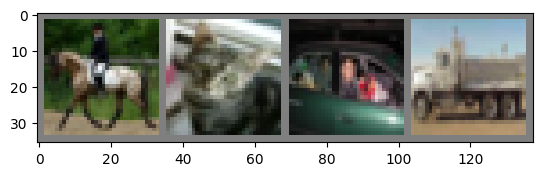

horse cat   car   truck


In [138]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Section 1: Define your CNN model
Define your xput layer, optimizer and loss criterion

In [139]:
import torch
import torch.nn as nn

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        
        # 1st Convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 2nd Convolutional layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 3rd Convolutional layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 4th Convolutional layer
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(num_features=256)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 1st Fully connected layer
        self.fc1 = nn.Linear(in_features=256*2*2, out_features=1024)
        self.bn5 = nn.BatchNorm1d(num_features=1024)
        self.relu5 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        
        # 2nd Fully connected layer
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.bn6 = nn.BatchNorm1d(num_features=512)
        self.relu6 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.5)
        
        # 3rd Fully connected layer
        self.fc3 = nn.Linear(in_features=512, out_features=256)
        self.bn7 = nn.BatchNorm1d(num_features=256)
        self.sig7 = nn.Sigmoid()
        self.dropout3 = nn.Dropout(p=0.5)
        
        # 4th Fully connected layer
        self.fc4 = nn.Linear(in_features=256, out_features=10)
    
    def forward(self, x):
        # Forward pass through the 1st Convolutional layer
        x = x.to(device='cuda')
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        # Forward pass through the 2nd Convolutional layer
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        # Forward pass through the 3rd Convolutional layer
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        # Forward pass through the 4th Convolutional layer
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool4(x)
        
        # Flatten the output from the convolutional layers for the fully connected layers
        x = torch.flatten(x, start_dim=1)
        
        # Forward pass through the 1st Fully connected layer
        x = self.fc1(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.dropout1(x)
        
        # Forward pass through the 2nd Fully connected layer
        x = self.fc2(x)
        x = self.bn6(x)
        x = self.relu6(x)
        x = self.dropout2(x)
        
        # Forward pass through the 3rd Fully connected layer
        x = self.fc3(x)
        x = self.bn7(x)
        x = self.sig7(x)
        x = self.dropout3(x)
        
        # Forward pass through the output layer
        x = self.fc4(x)
        
        return x

       


In [140]:
#create model
model = CustomCNN()

## Section 2: Define optimizer and loss criterion

In [144]:
# Hyperparameters
random_seed = random.seed(42)
learning_rate = 0.001
num_epochs = 5

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# loss
loss_function = nn.CrossEntropyLoss()

In [145]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', DEVICE)
# Set my pretrained model to be run on GPU
model = model.to(DEVICE)

Device: cuda:0


In [146]:
def train_model(trainloader, valid_loader, num_epochs, model, optimizer, loss_function):
    correct = 0
    total = 0
    for epoch in range(num_epochs):
      # Train the model
        model.train()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            #Zero out the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = loss_function(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        # Evaluate the model on the validation set
        model.eval()
        with torch.no_grad():
            total = 0
            correct = 0
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                              
                outputs = model(inputs)

            
            # Update statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        
            print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {running_loss / ((i + 1) * batch_size):.4f}, Train Accuracy: {correct*100/total:.2f}%")
            
        





In [147]:
# Define the number of folds
num_folds = 10

# Initialize KFold object
kf = KFold(n_splits=num_folds, shuffle=True)

# Get indices for each fold
fold_indices = []
for train_indices, valid_indices in kf.split(trainset):
    fold_indices.append((train_indices, valid_indices))
    

In [148]:
# Iterate over each fold and train the model
for i, (train_indices, valid_indices) in enumerate(fold_indices):
    # Create data loaders for the current fold
    train_sampler = data.SubsetRandomSampler(train_indices)
    valid_sampler = data.SubsetRandomSampler(valid_indices)
    train_loader = data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
    valid_loader = data.DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler)
    train_model(train_loader, valid_loader, num_epochs, model, optimizer, loss_function)

Epoch: 1/5, Train Loss: 0.0001, Train Accuracy: 25.00%
Epoch: 2/5, Train Loss: 0.0001, Train Accuracy: 50.00%
Epoch: 3/5, Train Loss: 0.0001, Train Accuracy: 75.00%
Epoch: 4/5, Train Loss: 0.0001, Train Accuracy: 50.00%
Epoch: 5/5, Train Loss: 0.0000, Train Accuracy: 75.00%
Epoch: 1/5, Train Loss: 0.0001, Train Accuracy: 100.00%
Epoch: 2/5, Train Loss: 0.0000, Train Accuracy: 50.00%
Epoch: 3/5, Train Loss: 0.0002, Train Accuracy: 50.00%
Epoch: 4/5, Train Loss: 0.0001, Train Accuracy: 100.00%
Epoch: 5/5, Train Loss: 0.0001, Train Accuracy: 100.00%
Epoch: 1/5, Train Loss: 0.0001, Train Accuracy: 75.00%
Epoch: 2/5, Train Loss: 0.0003, Train Accuracy: 75.00%
Epoch: 3/5, Train Loss: 0.0001, Train Accuracy: 75.00%
Epoch: 4/5, Train Loss: 0.0000, Train Accuracy: 75.00%
Epoch: 5/5, Train Loss: 0.0000, Train Accuracy: 100.00%
Epoch: 1/5, Train Loss: 0.0001, Train Accuracy: 100.00%
Epoch: 2/5, Train Loss: 0.0000, Train Accuracy: 100.00%
Epoch: 3/5, Train Loss: 0.0001, Train Accuracy: 100.00%
Epo

## Section 3: Test your model

In [149]:
dataiter = iter(testloader)
images, labels = next(dataiter)

In [150]:
#Test for the entire dataset

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our xputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        # calculate xputs by running images through the network
        xputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(xputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 78 %
